## Load a model!

In [1]:
import time
import os
import numpy as np

import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.loader import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)

import wandb
import pickle

from cancernet.arch import GCNNet, GATNet, InteractionNet
from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet

In [2]:
base_data_string="/mnt/home/cpedersen/ceph/Data/data"

dataset = PnetDataSet(
    root=os.path.join(base_data_string, "prostate"),
    name="prostate_graph_humanbase",
    # files={'graph_file': "global.geneSymbol.gz"},
    edge_tol=0.5,
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]),)

splits_root = os.path.join(base_data_string, "prostate", "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"))

pl.seed_everything(42, workers=True)

n_epochs = 10
batch_size = 10


test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.test_idx),
    generator=torch.Generator().manual_seed(43),
)


[rank: 0] Global seed set to 42


In [3]:
## Our best GCN
## https://wandb.ai/cancer-net/hyperparam_sweeps_May/runs/bv8vmf70/
model_gcn = GCNNet(dims=[3, 256, 256, 256], lr=0.0061575)
model_gcn.load_state_dict(torch.load("/mnt/home/cpedersen/ceph/cancer-net-models/hyperparam_sweeps/GCN_no_early/wandb/run-20230518_010814-bv8vmf70/files/model_weights.pt"))

## Our best GAT
## https://wandb.ai/cancer-net/hyperparam_sweeps_May/runs/qf3s2ze6
model_gat = GATNet(dims=[3, 32,32, 32], lr=0.0001017)
model_gat.load_state_dict(torch.load("/mnt/home/cpedersen/ceph/cancer-net-models/hyperparam_sweeps/GAT_no_early/wandb/run-20230518_001508-qf3s2ze6/files/model_weights.pt"))

## Our best MetaLayer
## https://wandb.ai/cancer-net/hyperparam_sweeps_May/runs/kg827ae8
model_metalayer = InteractionNet(layers=5,
                        hidden=64,
                        lr=0.000068689)
model_metalayer.load_state_dict(torch.load("/mnt/home/cpedersen/ceph/cancer-net-models/hyperparam_sweeps/MetaLayer_no_early/wandb/run-20230518_001513-kg827ae8/files/model_weights.pt"))

<All keys matched successfully>

In [4]:
test_data=next(iter(test_loader))

In [5]:
model_gcn(test_data)

tensor([[-0.8362, -0.5680],
        [-0.1971, -1.7208],
        [-0.4497, -1.0156],
        [-0.2993, -1.3522],
        [-0.0989, -2.3631],
        [-0.1181, -2.1947],
        [-0.0354, -3.3574],
        [-0.0176, -4.0513],
        [-1.9864, -0.1476],
        [-0.1999, -1.7084]], grad_fn=<LogSoftmaxBackward0>)

In [6]:
model_gat(test_data)

tensor([[-1.0710, -0.4196],
        [-0.4341, -1.0437],
        [-0.5017, -0.9301],
        [-0.2754, -1.4241],
        [-0.3296, -1.2700],
        [-0.3286, -1.2728],
        [-0.1009, -2.3437],
        [-0.0593, -2.8541],
        [-1.1784, -0.3678],
        [-0.0912, -2.4402]], grad_fn=<LogSoftmaxBackward0>)

In [7]:
model_metalayer(test_data)

tensor([[-1.3534, -0.2989],
        [-0.0173, -4.0664],
        [-1.3803, -0.2897],
        [-0.1701, -1.8554],
        [-0.0886, -2.4678],
        [-1.3373, -0.3046],
        [-0.0372, -3.3090],
        [-0.0558, -2.9132],
        [-2.2741, -0.1086],
        [-0.0346, -3.3803]], grad_fn=<LogSoftmaxBackward0>)

In [8]:
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model_metalayer, test_loader)

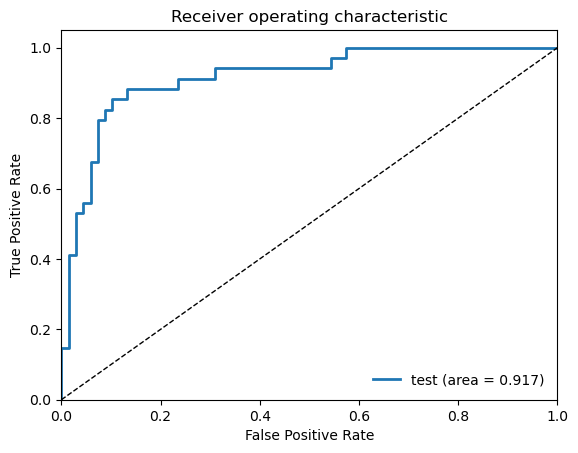

In [9]:
fig, ax = plt.subplots()
ax.plot(fpr_test, tpr_test, lw=2, label="test (area = %0.3f)" % test_auc)
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic")
ax.legend(loc="lower right", frameon=False)